## toolkit

### import the drive for ingesting dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### import necessary libraries and functions

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

# Segmentation

### preparing images

In [3]:
def load_and_prepare_image(image_path):
    sample_image_bgr = cv2.imread(image_path)
    sample_image_rgb = cv2.cvtColor(sample_image_bgr, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(sample_image_rgb, (64, 64))

    return resized_image

In [4]:
DATASET_DIR_PATH = '/content/drive/MyDrive/CV/Ass2/cvasg2'

In [5]:
relative_image_paths = [f for f in os.listdir(DATASET_DIR_PATH) if f.endswith('.jpg')]
print(relative_image_paths)

['image1.jpg', 'image2.jpg']


In [6]:
images = [load_and_prepare_image(os.path.join(DATASET_DIR_PATH, relative_image_path)) for relative_image_path in relative_image_paths]

In [7]:
image1, image2 = images[:2]

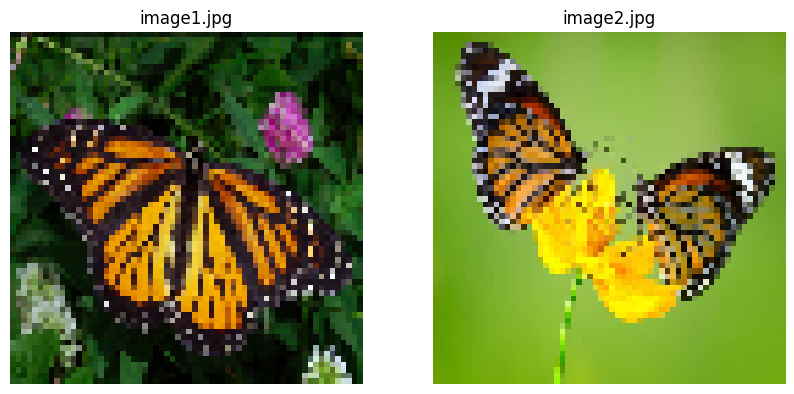

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1)
ax[0].axis('off')
ax[0].set_title(relative_image_paths[0])
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title(relative_image_paths[1])
plt.show()

### kmeans algorithm

In [9]:
def kmeans_segmentation(pixelArray_or_image, num_clusters, image_height_width=None):
    # assume input to be pixelArray
    pixelArray = pixelArray_or_image
    image = None
    # update if input is not pixelArray
    if len(pixelArray_or_image.shape) > 2:
        image = pixelArray_or_image

        if image_height_width != None:
            assert image.shape[:2] == image_height_width, f'image.shape[:2] doesnt match image_height_width'

        pixelArray = image.reshape(-1, image.shape[2])
    else:
        image = pixelArray.reshape((*image_height_width, pixelArray.shape[1]))

    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(pixelArray)

    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_[labels]
    clusters = clusters.astype(np.uint8).reshape(image.shape)

    labels = labels.reshape(image.shape[:2])

    return clusters, labels

In [10]:
image1_kmeans_3_clusters = kmeans_segmentation(pixelArray_or_image=image1, num_clusters=3)

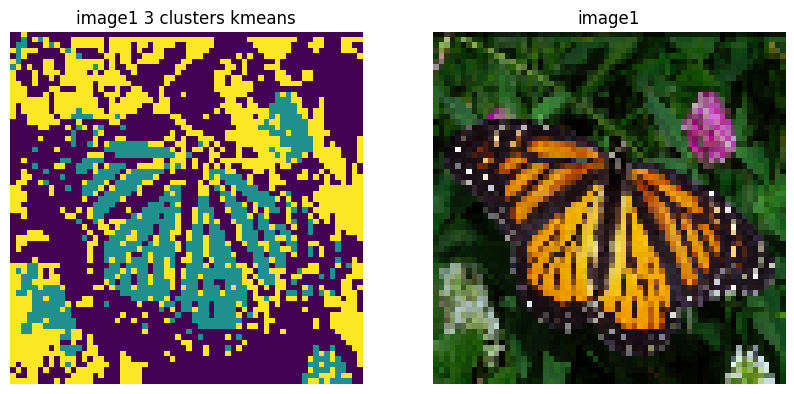

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1_kmeans_3_clusters[1])
ax[0].axis('off')
ax[0].set_title('image1 3 clusters kmeans')
ax[1].imshow(image1)
ax[1].axis('off')
ax[1].set_title('image1')
plt.show()

In [13]:
image1_kmeans_6_clusters = kmeans_segmentation(pixelArray_or_image=image1, num_clusters=6)

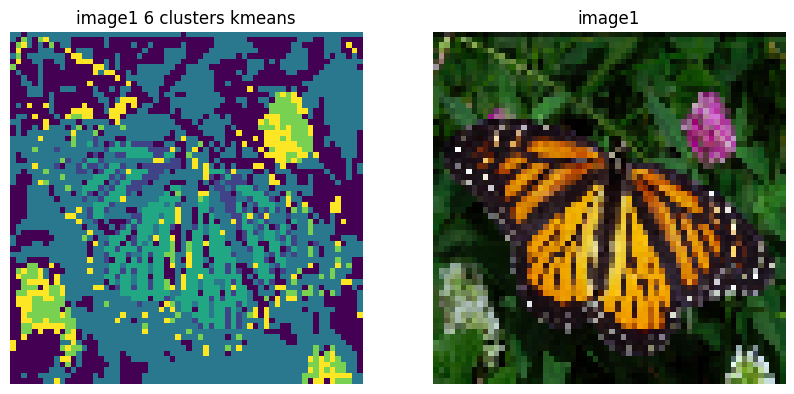

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1_kmeans_6_clusters[1])
ax[0].axis('off')
ax[0].set_title('image1 6 clusters kmeans')
ax[1].imshow(image1)
ax[1].axis('off')
ax[1].set_title('image1')
plt.show()

In [15]:
image2_kmeans_3_clusters = kmeans_segmentation(pixelArray_or_image=image2, num_clusters=3)

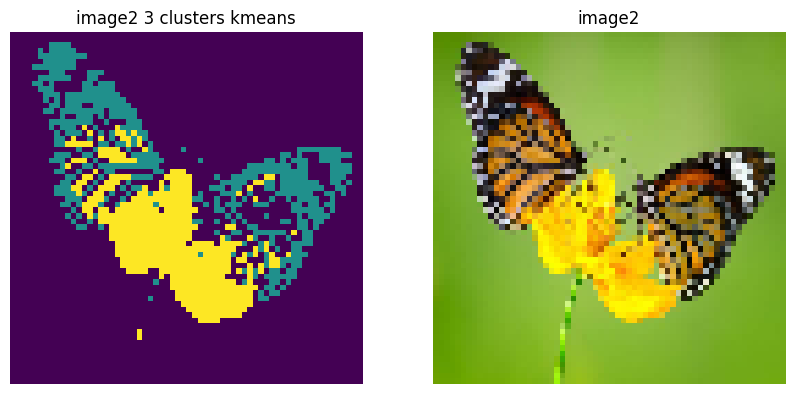

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image2_kmeans_3_clusters[1])
ax[0].axis('off')
ax[0].set_title('image2 3 clusters kmeans')
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title('image2')
plt.show()

In [17]:
image2_kmeans_6_clusters = kmeans_segmentation(pixelArray_or_image=image2, num_clusters=6)

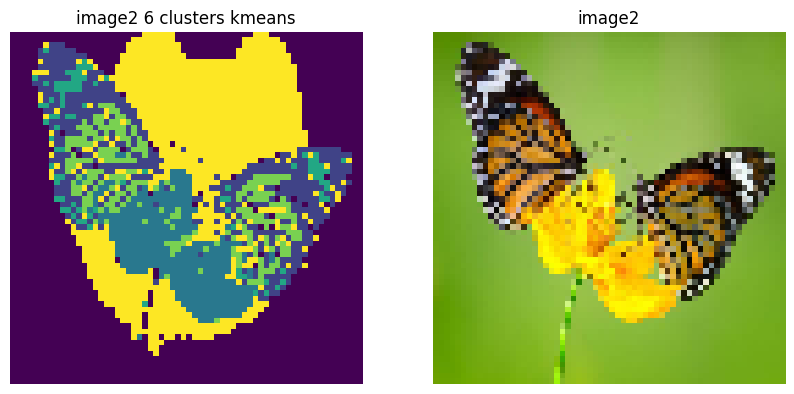

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image2_kmeans_6_clusters[1])
ax[0].axis('off')
ax[0].set_title('image2 6 clusters kmeans')
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title('image2')
plt.show()

### ratio cut algorithm

In [227]:
class RatioCutSegmentation():
    def __init__(self, image, num_pixel_neighbours, std_dev, lmbd):
        self.image = image
        self.adjacency_matrix = self.generate_adjacency_matrix(self.image, num_pixel_neighbours, std_dev, lmbd)


    def generate_adjacency_matrix(self, image, num_pixel_neighbours, std_dev, lmbd):
        print('computing adjacency matrix...')
        num_rows = image.shape[0]
        num_cols = image.shape[1]

        num_pixels = num_rows * num_cols
        adjacency_matrix = np.zeros((num_pixels, num_pixels))

        # num_skipped_0_pixels=0
        # num_skipped_oob_pixels=0
        # num_skipped_sym_pixels=0
        for ci in range(num_rows):
            for cj in range(num_cols):
                center_pixel_index = ci * num_cols + cj
                center_pixel_value = image[ci, cj]

                di_start_index = 0
                di_end_index = num_pixel_neighbours+1
                if di_end_index > num_rows - ci:
                    di_end_index = num_rows - ci

                for di in range(di_start_index, di_end_index):
                    dj_start_index = -num_pixel_neighbours
                    if di == 0:
                        dj_start_index = 1
                    else:
                        if dj_start_index < -cj:
                            dj_start_index = -cj

                    dj_end_index = num_pixel_neighbours+1
                    if dj_end_index > num_cols - cj:
                        dj_end_index = num_cols - cj


                    for dj in range(dj_start_index, dj_end_index):
                        # if di==dj==0:
                        #     # center pixel is not its neighbour
                        #     # adjacency value for center pixel with itself is 0
                        #     # and we already initialized matrix with 0 value
                        #     num_skipped_0_pixels+=1
                        #     continue

                        ni = ci + di
                        nj = cj + dj
                        # if not(0<=ni<num_rows and 0<=nj<num_cols):
                        #     # pixel index out of bounds
                        #     num_skipped_oob_pixels+=1
                        #     continue

                        neighbour_pixel_index = ni * num_cols + nj
                        # if neighbour_pixel_index < center_pixel_index:
                        #     # we compute values only for upper triangular matrix
                        #     # and paste the values for lower triangle
                        #     # since the matrix is symmetric
                        #     num_skipped_sym_pixels+=1
                        #     continue

                        neighbour_pixel_value = image[ni, nj]

                        pixel_dissimilarity = np.sum((center_pixel_value - neighbour_pixel_value)**2) + lmbd * ((ci-ni)**2 + (cj-nj)**2)
                        pixel_affinity = np.exp(-pixel_dissimilarity/(2*(std_dev**2)))

                        adjacency_matrix[center_pixel_index, neighbour_pixel_index] = pixel_affinity
                        adjacency_matrix[neighbour_pixel_index, center_pixel_index] = pixel_affinity

        print("computed adjacency matrix.")#, num_skipped_0_pixels, num_skipped_oob_pixels, num_skipped_sym_pixels)
        return adjacency_matrix


    def compute_clusters(self, num_clusters):
        # Calculate degree matrix
        degree_matrix = np.diag(np.count_nonzero(self.adjacency_matrix, axis=1))

        #Calculate laplacian matrix
        laplacian_matrix = degree_matrix - self.adjacency_matrix

        #Calculate the eigenvalues and eigenvectors of the laplacian matrix
        _, eigenvectors = np.linalg.eigh(laplacian_matrix)

        # feature matrix using k-smallest eigenvectors
        feature_matrix = eigenvectors[:, :num_clusters]

        # Perform KMeans clustering on the feature matrix
        _, labels = kmeans_segmentation(pixelArray_or_image=feature_matrix, num_clusters=num_clusters, image_height_width=self.image.shape[:2])
        clusters = np.zeros_like(self.image)
        for i in range(num_clusters):
            clusters[labels==i] = np.mean(self.image[labels == i], axis=0)

        return clusters, labels

In [238]:
image1_ratio_cutter = RatioCutSegmentation(
    image=image1,
    num_pixel_neighbours=image1.shape[0],
    std_dev=1000,
    lmbd=0.05
)

computing adjacency matrix...
computed adjacency matrix.


In [239]:
image1_ratio_cut_3_clusters = image1_ratio_cutter.compute_clusters(num_clusters=3)

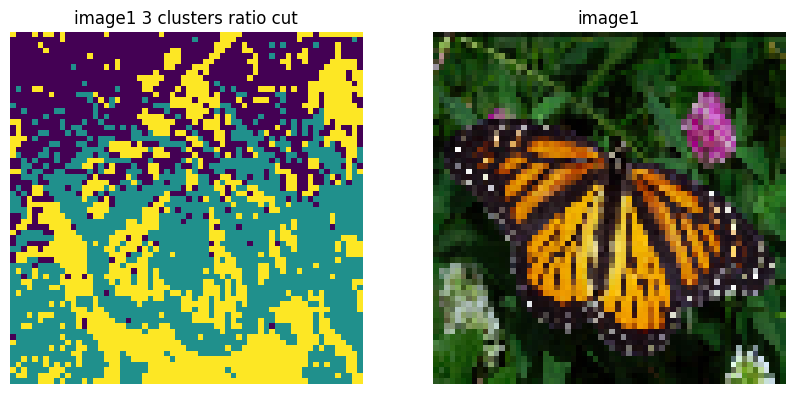

In [240]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1_ratio_cut_3_clusters[1])
ax[0].axis('off')
ax[0].set_title('image1 3 clusters ratio cut')
ax[1].imshow(image1)
ax[1].axis('off')
ax[1].set_title('image1')
plt.show()

In [241]:
image1_ratio_cut_6_clusters = image1_ratio_cutter.compute_clusters(num_clusters=6)

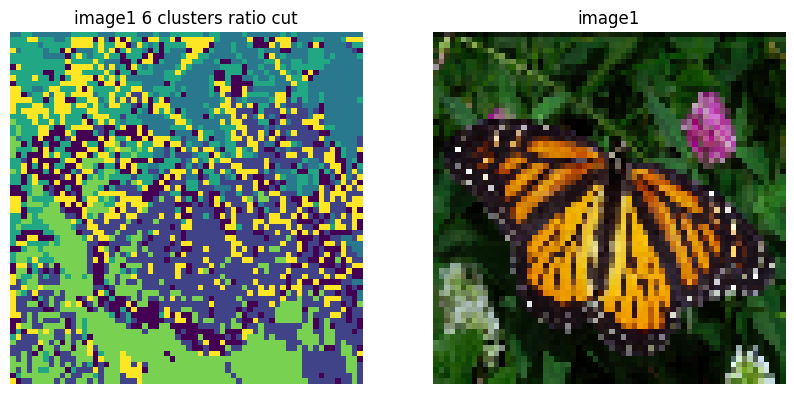

In [242]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image1_ratio_cut_6_clusters[1])
ax[0].axis('off')
ax[0].set_title('image1 6 clusters ratio cut')
ax[1].imshow(image1)
ax[1].axis('off')
ax[1].set_title('image1')
plt.show()

In [243]:
image2_ratio_cutter = RatioCutSegmentation(
    image=image2,
    num_pixel_neighbours=image2.shape[0],
    std_dev=1000,
    lmbd=0.05
)

computing adjacency matrix...
computed adjacency matrix.


In [244]:
image2_ratio_cut_3_clusters = image2_ratio_cutter.compute_clusters(num_clusters=3)

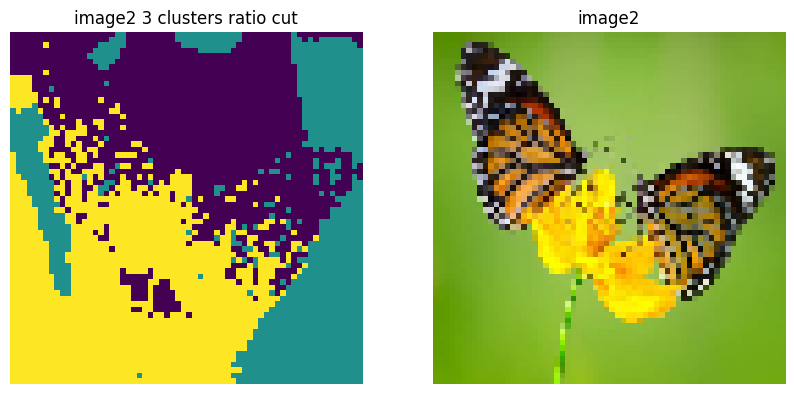

In [245]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image2_ratio_cut_3_clusters[1])
ax[0].axis('off')
ax[0].set_title('image2 3 clusters ratio cut')
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title('image2')
plt.show()

In [246]:
image2_ratio_cut_6_clusters = image2_ratio_cutter.compute_clusters(num_clusters=6)

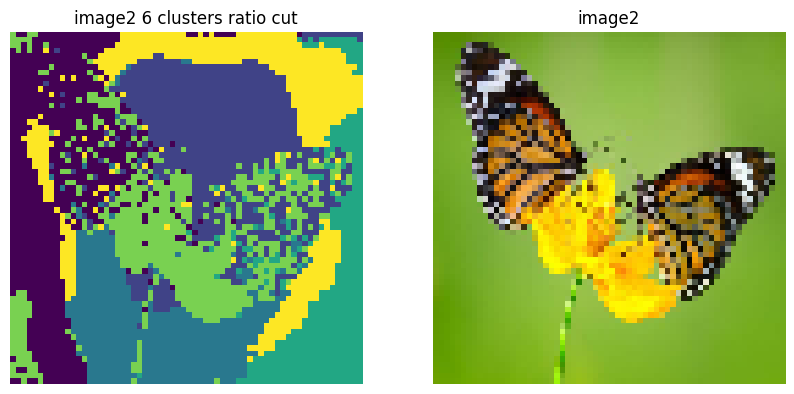

In [247]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image2_ratio_cut_6_clusters[1])
ax[0].axis('off')
ax[0].set_title('image2 6 clusters ratio cut')
ax[1].imshow(image2)
ax[1].axis('off')
ax[1].set_title('image2')
plt.show()